In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Generate synthetic social media analytics dataset
def generate_social_media_data(num_posts=2000, num_users=500):
    # Content types
    content_types = ['Image', 'Video', 'Text', 'Carousel', 'Story', 'Reel', 'Live']

    # Platforms
    platforms = ['Instagram', 'Facebook', 'Twitter', 'LinkedIn', 'TikTok']

    # Topics
    topics = [
        'Technology', 'Travel', 'Food', 'Fitness', 'Fashion',
        'Beauty', 'Business', 'Education', 'Entertainment', 'Sports'
    ]

    # Hashtags by topic
    topic_hashtags = {
        'Technology': ['#Tech', '#AI', '#Innovation', '#Digital', '#Programming'],
        'Travel': ['#Travel', '#Adventure', '#Wanderlust', '#Explore', '#Vacation'],
        'Food': ['#Food', '#Foodie', '#Recipe', '#Cooking', '#Delicious'],
        'Fitness': ['#Fitness', '#Workout', '#Health', '#Gym', '#Wellness'],
        'Fashion': ['#Fashion', '#Style', '#Outfit', '#Trend', '#Design'],
        'Beauty': ['#Beauty', '#Makeup', '#Skincare', '#Cosmetics', '#SelfCare'],
        'Business': ['#Business', '#Entrepreneur', '#Leadership', '#Success', '#Marketing'],
        'Education': ['#Education', '#Learning', '#Knowledge', '#Study', '#School'],
        'Entertainment': ['#Entertainment', '#Movie', '#Music', '#Celebrity', '#Fun'],
        'Sports': ['#Sports', '#Athlete', '#Game', '#Competition', '#Fitness']
    }

    # Generate post data
    post_data = []
    for post_id in range(1, num_posts + 1):
        # Select random topic
        topic = np.random.choice(topics)

        # Generate hashtags based on topic
        base_hashtags = topic_hashtags[topic]
        num_hashtags = np.random.randint(3, 8)
        hashtags = list(np.random.choice(base_hashtags, num_hashtags, replace=True))

        # Add some general hashtags
        general_hashtags = ['#SocialMedia', '#Trending', '#Viral', '#Follow', '#Like']
        num_general = np.random.randint(1, 4)
        hashtags.extend(np.random.choice(general_hashtags, num_general, replace=False))

        # Create caption
        captions = {
            'Technology': f"Exploring the latest in {topic} innovation and digital transformation.",
            'Travel': f"Amazing experiences and destinations for {topic.lower()} enthusiasts.",
            'Food': f"Delicious {topic.lower()} recipes and culinary inspirations.",
            'Fitness': f"{topic} tips and routines for a healthier lifestyle.",
            'Fashion': f"Trendsetting {topic.lower()} styles and outfit ideas.",
            'Beauty': f"Beautiful {topic.lower()} tips and product recommendations.",
            'Business': f"Insights and strategies for {topic.lower()} success.",
            'Education': f"Learning resources and {topic.lower()} insights.",
            'Entertainment': f"Latest in {topic.lower()} news and celebrity updates.",
            'Sports': f"Exciting {topic.lower()} events and athlete highlights."
        }

        caption = captions[topic] + " " + " ".join(hashtags)

        # Select content type and platform
        content_type = np.random.choice(content_types)
        platform = np.random.choice(platforms)

        # Generate post time (mostly during business hours)
        hour = np.random.normal(14, 3)  # Peak around 2 PM
        hour = max(9, min(20, int(hour)))  # Limit between 9 AM and 8 PM
        minute = np.random.randint(0, 60)

        # Generate engagement metrics (varies by platform, content type, and time)
        base_engagement = {
            'Instagram': {'Image': 500, 'Video': 800, 'Carousel': 600, 'Story': 300, 'Reel': 1200, 'Live': 1500, 'Text': 200},
            'Facebook': {'Image': 400, 'Video': 700, 'Carousel': 500, 'Story': 250, 'Reel': 1000, 'Live': 1300, 'Text': 300},
            'Twitter': {'Image': 300, 'Video': 500, 'Carousel': 400, 'Story': 200, 'Reel': 800, 'Live': 1000, 'Text': 400},
            'LinkedIn': {'Image': 200, 'Video': 400, 'Carousel': 300, 'Story': 150, 'Reel': 600, 'Live': 800, 'Text': 500},
            'TikTok': {'Image': 100, 'Video': 1200, 'Carousel': 200, 'Story': 100, 'Reel': 1500, 'Live': 1000, 'Text': 50}
        }

        # Adjust for time of day (higher engagement during peak hours)
        time_factor = 1.0
        if 11 <= hour <= 13:  # Lunch time
            time_factor = 1.3
        elif 17 <= hour <= 19:  # Evening
            time_factor = 1.2
        elif hour < 9 or hour > 19:  # Outside business hours
            time_factor = 0.7

        # Calculate engagement metrics
        base_val = base_engagement[platform][content_type]
        likes = int(np.random.normal(base_val * time_factor, base_val * 0.3))
        shares = int(np.random.normal(base_val * 0.1 * time_factor, base_val * 0.03))
        comments = int(np.random.normal(base_val * 0.05 * time_factor, base_val * 0.02))

        # Ensure non-negative values
        likes = max(0, likes)
        shares = max(0, shares)
        comments = max(0, comments)

        # Calculate engagement rate
        followers = np.random.normal(10000, 3000)  # Simulated follower count
        engagement_rate = (likes + shares * 2 + comments * 3) / followers if followers > 0 else 0

        post_data.append({
            'post_id': post_id,
            'user_id': np.random.randint(1, num_users + 1),
            'platform': platform,
            'content_type': content_type,
            'topic': topic,
            'caption': caption,
            'hashtags': ' '.join(hashtags),
            'post_hour': hour,
            'likes': likes,
            'shares': shares,
            'comments': comments,
            'engagement_rate': engagement_rate,
            'followers': int(followers)
        })

    posts_df = pd.DataFrame(post_data)

    # Generate user preferences
    user_data = []
    for user_id in range(1, num_users + 1):
        # Each user has preferences for certain content types and topics
        preferred_content = np.random.choice(content_types, size=np.random.randint(2, 5), replace=False)
        preferred_topics = np.random.choice(topics, size=np.random.randint(3, 6), replace=False)

        user_data.append({
            'user_id': user_id,
            'preferred_content': ', '.join(preferred_content),
            'preferred_topics': ', '.join(preferred_topics),
            'primary_platform': np.random.choice(platforms)
        })

    users_df = pd.DataFrame(user_data)

    return posts_df, users_df

In [5]:
# Generate the dataset
print("Generating social media analytics dataset...")
posts_df, users_df = generate_social_media_data()

print(f"Generated {len(posts_df)} posts from {len(users_df)} users")

Generating social media analytics dataset...
Generated 2000 posts from 500 users


In [6]:
# Display sample data
print("\nSample posts:")
print(posts_df[['platform', 'content_type', 'topic', 'likes', 'engagement_rate']].head(3))
print("\nSample users:")
print(users_df.head(3))


Sample posts:
   platform content_type      topic  likes  engagement_rate
0    TikTok         Text   Business     57         0.031685
1  Facebook         Reel       Food    819         0.071480
2  Facebook         Live  Education   1643         0.172063

Sample users:
   user_id  preferred_content  \
0        1  Live, Text, Story   
1        2         Text, Live   
2        3        Text, Story   

                                    preferred_topics primary_platform  
0                   Education, Sports, Entertainment         Facebook  
1     Fitness, Technology, Beauty, Education, Travel         Facebook  
2  Education, Fitness, Sports, Fashion, Entertain...          Twitter  


In [7]:
# Content-Based Filtering
print("\nBuilding Content-Based Filtering Model...")

# Create TF-IDF matrix from post captions, hashtags, and topics
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(posts_df['caption'] + " " + posts_df['hashtags'] + " " + posts_df['topic'])

# Compute cosine similarity matrix
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)


Building Content-Based Filtering Model...


In [8]:
# Function to get content-based recommendations
def content_based_recommendations(post_id, top_n=10):
    # Get the index of the post
    idx = posts_df[posts_df['post_id'] == post_id].index[0]

    # Get similarity scores for all posts
    sim_scores = list(enumerate(content_similarity[idx]))

    # Sort posts based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N most similar posts (excluding itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get post indices
    post_indices = [i[0] for i in sim_scores]

    # Return the top N most similar posts
    return posts_df.iloc[post_indices]

In [9]:
# Collaborative Filtering using Matrix Factorization
print("Building Collaborative Filtering Model...")

# Create user-post engagement matrix
user_post_engagement = posts_df.pivot_table(
    index='user_id',
    columns='post_id',
    values='engagement_rate',
    fill_value=0
)

# Normalize the data
scaler = MinMaxScaler()
user_post_engagement_norm = pd.DataFrame(
    scaler.fit_transform(user_post_engagement),
    index=user_post_engagement.index,
    columns=user_post_engagement.columns
)

# Apply SVD for matrix factorization
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_features = svd.fit_transform(user_post_engagement_norm)
post_features = svd.components_.T

# Reconstruct the matrix
predicted_engagement = np.dot(user_features, post_features.T)

# Convert back to DataFrame
predicted_engagement_df = pd.DataFrame(
    predicted_engagement,
    index=user_post_engagement.index,
    columns=user_post_engagement.columns
)

Building Collaborative Filtering Model...


In [10]:
# Function to get collaborative filtering recommendations
def collaborative_recommendations(user_id, top_n=10):
    # Get predicted engagement for the user
    user_predictions = predicted_engagement_df.loc[user_id]

    # Get posts already engaged with by the user
    user_posts = posts_df[posts_df['user_id'] == user_id]['post_id'].values

    # Filter out already engaged posts
    recommendations = user_predictions[~user_predictions.index.isin(user_posts)]

    # Sort by predicted engagement
    recommendations = recommendations.sort_values(ascending=False)

    # Get top N recommendations
    top_recommendations = recommendations.head(top_n)

    # Return post details
    return posts_df[posts_df['post_id'].isin(top_recommendations.index)]

In [11]:
# Hybrid Recommendation System
print("Building Hybrid Recommendation System...")

def hybrid_recommendations(user_id, post_id=None, top_n=10, content_weight=0.4, collab_weight=0.6):
    # If no post_id provided, use the highest engaged post by the user
    if post_id is None:
        user_posts = posts_df[posts_df['user_id'] == user_id]
        if len(user_posts) > 0:
            post_id = user_posts.sort_values('engagement_rate', ascending=False).iloc[0]['post_id']
        else:
            # If user has no posts, use most engaged post overall
            post_id = posts_df.sort_values('engagement_rate', ascending=False).iloc[0]['post_id']

    # Get content-based recommendations
    content_recs = content_based_recommendations(post_id, top_n*3)
    content_recs['content_score'] = range(len(content_recs), 0, -1)  # Higher score for better recommendations

    # Get collaborative filtering recommendations
    collab_recs = collaborative_recommendations(user_id, top_n*3)
    collab_recs = collab_recs.merge(
        predicted_engagement_df.loc[user_id].reset_index(),
        left_on='post_id', right_on='post_id'
    )
    collab_recs.rename(columns={user_id: 'collab_score'}, inplace=True)

    # Merge the two recommendation sets
    hybrid_recs = pd.merge(
        content_recs[['post_id', 'content_score']],
        collab_recs[['post_id', 'collab_score']],
        on='post_id',
        how='outer'
    ).fillna(0)

    # Normalize scores
    scaler = MinMaxScaler()
    hybrid_recs['content_score_norm'] = scaler.fit_transform(hybrid_recs[['content_score']])
    hybrid_recs['collab_score_norm'] = scaler.fit_transform(hybrid_recs[['collab_score']])

    # Calculate hybrid score
    hybrid_recs['hybrid_score'] = (content_weight * hybrid_recs['content_score_norm'] +
                                  collab_weight * hybrid_recs['collab_score_norm'])

    # Sort by hybrid score
    hybrid_recs = hybrid_recs.sort_values('hybrid_score', ascending=False)

    # Get top N recommendations
    top_hybrid = hybrid_recs.head(top_n)

    # Merge with post details
    result = top_hybrid.merge(posts_df, on='post_id')

    return result[['post_id', 'platform', 'content_type', 'topic', 'engagement_rate', 'hybrid_score']]

Building Hybrid Recommendation System...


In [12]:
# Strategy Recommendation Function
def recommend_strategy(user_id):
    # Get user's historical performance
    user_posts = posts_df[posts_df['user_id'] == user_id]

    if len(user_posts) == 0:
        # If no posts, return general recommendations
        return {
            'best_platform': 'Instagram',
            'best_content_type': 'Reel',
            'best_topic': 'Entertainment',
            'best_time': '2 PM',
            'reasoning': 'General recommendations based on overall platform performance'
        }

    # Find best performing platform
    platform_performance = user_posts.groupby('platform')['engagement_rate'].mean()
    best_platform = platform_performance.idxmax()

    # Find best performing content type
    content_performance = user_posts.groupby('content_type')['engagement_rate'].mean()
    best_content_type = content_performance.idxmax()

    # Find best performing topic
    topic_performance = user_posts.groupby('topic')['engagement_rate'].mean()
    best_topic = topic_performance.idxmax()

    # Find best posting time
    time_performance = user_posts.groupby('post_hour')['engagement_rate'].mean()
    best_time = f"{int(time_performance.idxmax())}:00"

    return {
        'best_platform': best_platform,
        'best_content_type': best_content_type,
        'best_topic': best_topic,
        'best_time': best_time,
        'reasoning': 'Based on your historical performance data'
    }

In [13]:
# Evaluation
print("Evaluating the recommendation system...")

# Split posts into train and test sets
train_posts, test_posts = train_test_split(posts_df, test_size=0.2, random_state=42)

# Create train user-post engagement matrix
train_engagement = train_posts.pivot_table(
    index='user_id',
    columns='post_id',
    values='engagement_rate',
    fill_value=0
)

# Normalize the train data
train_engagement_norm = pd.DataFrame(
    scaler.fit_transform(train_engagement),
    index=train_engagement.index,
    columns=train_engagement.columns
)

# Apply SVD on train data
svd_train = TruncatedSVD(n_components=n_components, random_state=42)
user_features_train = svd_train.fit_transform(train_engagement_norm)
post_features_train = svd_train.components_.T

# Reconstruct the matrix
predicted_engagement_train = np.dot(user_features_train, post_features_train.T)

# Calculate RMSE for collaborative filtering
test_engagement = test_posts.pivot_table(
    index='user_id',
    columns='post_id',
    values='engagement_rate',
    fill_value=0
)

# Align test matrix with train matrix
test_engagement_aligned = test_engagement.reindex(
    index=train_engagement.index,
    columns=train_engagement.columns,
    fill_value=0
)

# Calculate RMSE
y_true = []
y_pred = []
for _, row in test_posts.iterrows():
    user_id = row['user_id']
    post_id = row['post_id']

    if user_id in train_engagement.index and post_id in train_engagement.columns:
        y_true.append(row['engagement_rate'])
        y_pred.append(predicted_engagement_train[
            train_engagement.index.get_loc(user_id),
            train_engagement.columns.get_loc(post_id)
        ])

rmse = np.sqrt(mean_squared_error(y_true, y_pred)) if y_true else 0
print(f"Collaborative Filtering RMSE: {rmse:.4f}")

Evaluating the recommendation system...
Collaborative Filtering RMSE: 0.0000


Precision@5: 0.0000, Recall@5: 0.0000
Precision@10: 0.0000, Recall@10: 0.0000
Precision@15: 0.0000, Recall@15: 0.0000

Sample Recommendations for User 1:
    platform content_type     topic  engagement_rate  hybrid_score
0  Instagram        Video    Sports         0.108689      0.946667
1   Facebook        Video    Sports         0.079491      0.873358
2  Instagram         Text   Fashion         0.030665      0.600000
3    Twitter        Image   Fashion         0.043306      0.600000
4    Twitter         Live  Business         0.837779      0.600000
5   Facebook         Reel  Business         0.114050      0.600000
6    Twitter         Text   Fashion         0.065821      0.600000
7    Twitter     Carousel  Business         0.134681      0.600000
8     TikTok     Carousel      Food         0.041224      0.585793
9  Instagram         Reel   Fitness         0.284728      0.585793

Strategy Recommendations for User 1:
best_platform: Facebook
best_content_type: Video
best_topic: Sports
bes

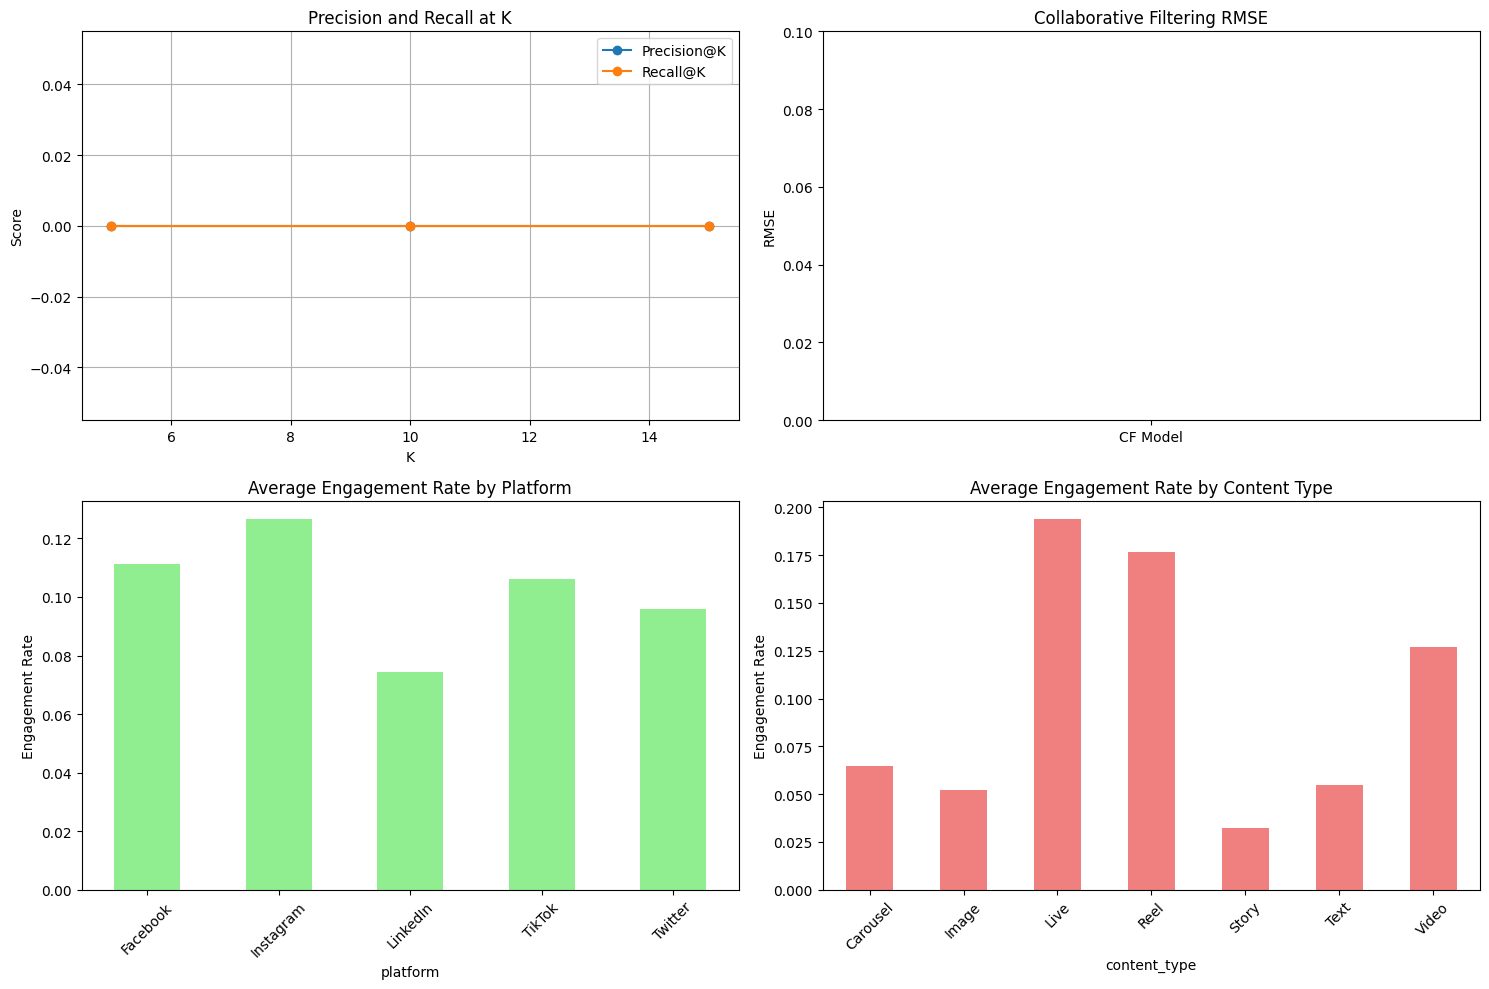


Social media analytics recommendation system implementation completed!
Metrics visualization saved as 'social_media_recommendation_metrics.png'


In [14]:
# Evaluate precision and recall for hybrid recommendations
def evaluate_hybrid(top_k=10):
    # For a sample of users
    sample_users = posts_df['user_id'].unique()[:50]  # Use first 50 users for evaluation

    precisions = []
    recalls = []

    for user_id in sample_users:
        # Get user's highly engaged posts (engagement_rate >= 0.05)
        user_high_engagement = posts_df[(posts_df['user_id'] == user_id) & (posts_df['engagement_rate'] >= 0.05)]
        relevant_items = set(user_high_engagement['post_id'].values)

        if len(relevant_items) == 0:
            continue

        # Get hybrid recommendations
        hybrid_recs = hybrid_recommendations(user_id, top_n=top_k)
        recommended_items = set(hybrid_recs['post_id'].values)

        # Calculate precision and recall
        if len(recommended_items) > 0:
            true_positives = len(relevant_items.intersection(recommended_items))
            precision = true_positives / len(recommended_items)
            recall = true_positives / len(relevant_items)

            precisions.append(precision)
            recalls.append(recall)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    return avg_precision, avg_recall

# Evaluate for different values of K
k_values = [5, 10, 15]
results = {}

for k in k_values:
    precision, recall = evaluate_hybrid(top_k=k)
    results[k] = {'Precision': precision, 'Recall': recall}
    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")

# Generate sample recommendations
print("\nSample Recommendations for User 1:")
user_id = 1
sample_recommendations = hybrid_recommendations(user_id, top_n=10)
print(sample_recommendations[['platform', 'content_type', 'topic', 'engagement_rate', 'hybrid_score']])

# Generate strategy recommendations
print("\nStrategy Recommendations for User 1:")
strategy = recommend_strategy(user_id)
for key, value in strategy.items():
    print(f"{key}: {value}")

# Visualization
plt.figure(figsize=(15, 10))

# Plot Precision@K and Recall@K
plt.subplot(2, 2, 1)
precisions = [results[k]['Precision'] for k in k_values]
recalls = [results[k]['Recall'] for k in k_values]
plt.plot(k_values, precisions, marker='o', label='Precision@K')
plt.plot(k_values, recalls, marker='o', label='Recall@K')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Precision and Recall at K')
plt.legend()
plt.grid(True)

# Plot RMSE
plt.subplot(2, 2, 2)
plt.bar(['CF Model'], [rmse], color='skyblue')
plt.ylabel('RMSE')
plt.title('Collaborative Filtering RMSE')
plt.ylim(0, max(rmse * 1.5, 0.1))

# Plot platform performance
plt.subplot(2, 2, 3)
platform_perf = posts_df.groupby('platform')['engagement_rate'].mean()
platform_perf.plot(kind='bar', color='lightgreen')
plt.title('Average Engagement Rate by Platform')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)

# Plot content type performance
plt.subplot(2, 2, 4)
content_perf = posts_df.groupby('content_type')['engagement_rate'].mean()
content_perf.plot(kind='bar', color='lightcoral')
plt.title('Average Engagement Rate by Content Type')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('social_media_recommendation_metrics.png')
plt.show()

print("\nSocial media analytics recommendation system implementation completed!")
print("Metrics visualization saved as 'social_media_recommendation_metrics.png'")